## Importing modules

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F

from tqdm import tqdm

#import image_embedding
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
targets=torch.tensor([[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4],[0,1,2,3,4]])
B,T= targets.shape
shifted_tensor = torch.full((B, T), 112, dtype=targets.dtype)
shifted_tensor[:, :-1] = targets[:, 1:]
print(targets)
print(shifted_tensor)

tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])
tensor([[  1,   2,   3,   4, 112],
        [  1,   2,   3,   4, 112],
        [  1,   2,   3,   4, 112],
        [  1,   2,   3,   4, 112]])


# Hyper-parameters

In [ ]:
batch_size = 128 # how many independent sequences will we process in parallel?

max_iters = 5
eval_interval = 50
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10

n_embd_encoder = 144
n_embd_decoder = 288


n_head_encoder = 8
n_head_decoder = 16

n_layer_decoder = 6
n_layer_encoder = 1

dropout = 0.3
#---------------
alpha=0.4
# ------------
resNet_embed=512
Bert_n_embd=768
query_embd=Bert_n_embd
vocab_size_Bert=30522
#---------------
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1337)
print("CUDA available:", torch.cuda.is_available())
print("Device being used:", device)

CUDA available: True
Device being used: cuda


Reading **annotations**

In [ ]:
# Open the TSV file
x=[]
y=[]
with open('/content/drive/My Drive/video_captionning/tgif-v1.0.tsv', 'r') as file:
    # Read all lines
    lines = file.readlines()

    # Iterate through the lines
    for line in lines:
        # Split each line by the tab character
        columns = line.strip().split('\t')
        x.append(columns[0])
        y.append(columns[1])
print(y[:5])

['a man is glaring, and someone with sunglasses appears.', 'a cat tries to catch a mouse on a tablet', 'a man dressed in red is dancing.', 'an animal comes close to another in the jungle', 'a man in a hat adjusts his tie and makes a weird face.']


### A gif example

In [ ]:
print(x[436])

https://38.media.tumblr.com/95a43150244b2b959bd419061b15321b/tumblr_np56xtbeg91u7lo0fo1_400.gif


## extracting frames from gifs

In [ ]:
import requests
from PIL import Image
from io import BytesIO


def get_gif_frames(gif_url):
    #Download the GIF
    response = requests.get(gif_url)
    gif_data = BytesIO(response.content)

    # Open the GIF and extract frames
    with Image.open(gif_data) as gif:
        frames = []
        try:
            while True:
                # Save each frame to the frames list
                frames.append(gif.copy())
                gif.seek(gif.tell() + 1)
        except EOFError:
            pass
    return frames
# URL of the GIF
gif_url = x[2000]
frames=get_gif_frames(gif_url)


## Pre-Processing the frames

In [ ]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
#input_tensor = preprocess(frames[16].convert('RGB'))
#input_batch = input_tensor.unsqueeze(0).to(device)

### Testing the pre-process

60


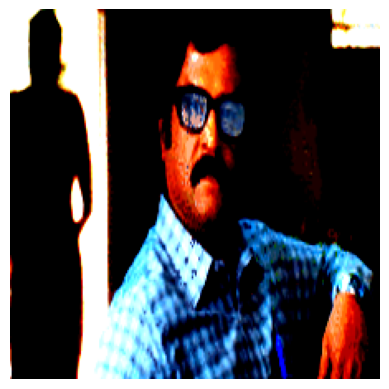

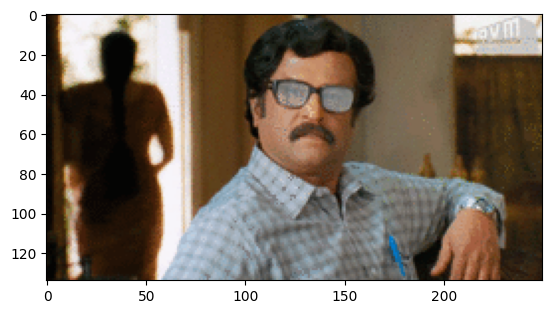

In [ ]:
import matplotlib.pyplot as plt
print(len(frames))
input_tensor = preprocess(frames[16].convert('RGB'))
plt.figure()
plt.imshow(input_tensor.permute(1, 2, 0))

plt.axis('off')  # better visualization
plt.show()
plt.figure()
plt.imshow(frames[16])
plt.show()

## Extracting Frame feautures with ResNet18 Backbone

In [ ]:
import torchvision.models as models
cnn = models.resnet18(weights='IMAGENET1K_V1').to(device).eval()

cnn.requires_grad_(False) # freezing the backbone
cnn = nn.Sequential(*list(cnn.children())[:-1]) # removing the last layer



#cnn.classifier = nn.Sequential(*[cnn.classifier[i] for i in range(4)])
#cnn.fc = nn.Linear(cnn.fc.in_features, 576).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.3MB/s]


In [ ]:
# check which parameters are trainable
for param in cnn.parameters():
    if param.requires_grad:
        print(f"Trainable parameter: ")

In [ ]:
out=cnn(input_batch).squeeze()

## Saving the latent (Resnet18) Image features to save on training time

In [ ]:
for k in range(10):
    video_embeddings = []
    y_moment=[]
    for j,gif_url in tqdm(enumerate(x[15000+k*1000:15000+(k+1)*1000])):

        frames = get_gif_frames(gif_url)

        if len(frames)>1:
            y_moment.append(y[j+15000+k*1000])
            step=len(frames)//16
            frame_embeddings = torch.stack([(preprocess(frames[i*step].convert('RGB'))) for i in range(16)])
            frame_embeddings=frame_embeddings.to(device)
            frame_embeddings = cnn(frame_embeddings).squeeze()
            video_embeddings.append(frame_embeddings)

    padded_x=pad_sequence(video_embeddings, batch_first=True, padding_value=0)

    print(padded_x.size())
    torch.save(padded_x, '/content/drive/My Drive/video_captionning/padded_x_tensor_resNet_'+str(12+k)+'.pt')
    torch.save(y_moment, '/content/drive/My Drive/video_captionning/padded_y_tensor_resNet_'+str(12+k)+'.pt')

1000it [29:54,  1.79s/it]


torch.Size([983, 16, 512])


100it [03:16,  1.61s/it]

## Tokenization (Bert Tokenizer)

In [ ]:
from transformers import BertTokenizer
from transformers import BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# def tokenize(marked_text):
#     tokenized_text = tokenizer.tokenize(marked_text)
#     indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#     return indexed_tokens

# encoded_y= list(map(tokenize,y))
# print(encoded_y[:10])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Tokenizing the caption with BERT pre-trained Model

In [ ]:

def embedd(y):
    encoding = tokenizer.batch_encode_plus(y ,                    # List of input texts
    padding=True,
    truncation=True,
    return_tensors='pt',
    add_special_tokens=True
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    return input_ids,attention_mask

## Loading the saved frames Image Features / and corresponding Captions

In [ ]:
padded_x_1 = torch.load('/content/drive/My Drive/video_captionning/padded_x_tensor_resNet_1.pt', map_location=torch.device(device))
padded_x=padded_x_1
#22
for i in range(2,3):
    loaded_x= torch.load('/content/drive/My Drive/video_captionning/padded_x_tensor_resNet_'+str(i)+'.pt', map_location=torch.device(device))
    padded_x=torch.cat([padded_x,loaded_x],0)
    torch.cuda.empty_cache()


frame_block_size= 16
y_inter=y[:2000]
for i in range(3,3):
    y_inter=y_inter+torch.load(f'/content/drive/My Drive/video_captionning/padded_y_tensor_resNet_{i}.pt')

print(len(y_inter))


<ipython-input-7-854ee7daf0a2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  padded_x_1 = torch.load('/content/drive/My Drive/video_captionning/padded_x_tensor_resNet_1.p

2000
2000


## Tokenizing the captions

In [ ]:
y_encoded,attention_mask=embedd(y_inter)

In [ ]:
print(y_encoded.size())
print(y_encoded[0])
print(attention_mask[0])

torch.Size([63843, 31])
tensor([  101,  1037,  2158,  2003, 16124,  1010,  1998,  2619,  2007, 17072,
         3544,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])


## train/dev split

In [ ]:
size=padded_x.size()[0]
print(size)
n = int(0.98*size)
y_encoded1,attention_mask1=y_encoded[0:size],attention_mask[0:size]
#creating train/dev set
y_train_data = y_encoded1[:n]
y_val_data = y_encoded1[n:batch]

attention_mask_train=attention_mask1[:n]
attention_mask_val=attention_mask1[n:batch]

x_train_data = padded_x[:n]
x_val_data = padded_x[n:]

# two essential parameters for the architecture
block_size=y_encoded.size()[1]
vocab_size=padded_x.size()[2]

### Batching function

In [ ]:
def get_batch(split,iter):
    # generate a small batch of data of inputs x and targets y
    if iter==None:
        ix = torch.randperm(len(x_train_data))[:batch_size]
    else:
      if iter< len(x_train_data)//batch_size:
          ix= list(range(iter*batch_size, (iter+1)*batch_size))
      else:
          ix= list(range(len(x_train_data)-batch_size, len(x_train_data)))
    #torch.randint(len(x_train_data)-1 , (batch_size,))
    ix_val = torch.randint(len(x_val_data) , (batch_size,))
    if split == 'train':
        y = torch.stack([y_train_data[i] for i in ix])
        x = torch.stack([x_train_data[i] for i in ix])
        attention_mask_batched=torch.stack([attention_mask_train[i] for i in ix])


    else:
        x = torch.stack([x_val_data[i] for i in ix_val])
        y = torch.stack([y_val_data[i] for i in ix_val])
        attention_mask_batched=torch.stack([attention_mask_val[i] for i in ix_val])

    x, y = x.to(device), y.to(device)

    return x, y,attention_mask_batched.to(device)

## Averaging Loss on a number of eval_iters for better Loss Estimation

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    flag_train=False
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y ,attention= get_batch(split,None)
            #with torch.autocast(device_type=device,dtype=torch.bfloat16):
            logits, loss = model(X, Y,attention)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    flag_train=True
    return out

## Custom Loss for Contrastive learning

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, x_cls, mean_enc_output,B):
        contrastive_dot = torch.exp(mean_enc_output @ x_cls.transpose(0,1)+1e-8)
        diagonal_elements = torch.diagonal(contrastive_dot)
        true_text_sum = torch.sum(contrastive_dot, dim=1)
        true_vid_sum = torch.sum(contrastive_dot, dim=0)
        contrastive_loss =  - (torch.sum(torch.log(diagonal_elements/(true_text_sum+1e-8)) + torch.log(diagonal_elements/(true_vid_sum+1e-8))))/(2*B)
        return contrastive_loss

## Model architecture

In [ ]:
#----------------------------------------------------------------------------------------------------------------

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, n_embd,head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        #self.register_buffer('tril', torch.tril(torch.ones(mask_size,mask_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, Q,K,V):

        k = self.key(K)   # (B,T,C)
        q = self.query(Q) # (B,T,C)
        v = self.value(V) # (B,T,C)

        B,T,C = q.shape
        B,T1,C=k.shape
        # # compute attention scores ("affinities")
        # wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:wei.shape[1], :wei.shape[2]] == 0, float('-inf')) # (B, T, T)
        # wei = F.softmax(wei, dim=-1) # (B, T, T)
        # wei = self.dropout(wei)
        # # perform the weighted aggregation of the values
        # out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

        out=F.scaled_dot_product_attention(q,k,v,dropout_p=dropout,is_causal=True) # Flash attention

        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_embd,num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embd,head_size) for _ in range(num_heads)])


    def forward(self, Q,K,V):
        out = torch.cat([h(Q,K,V) for h in self.heads], dim=-1)
        return out
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd,n_embd_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd_out),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
class EncoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):

        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_embd,n_head, head_size)
        self.ff = nn.Linear(n_embd,n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x_norm=self.ln1(x)
        x = x + self.sa(x_norm,x_norm,x_norm)
        x = x + self.ff(self.ln2(x))
        return x

class DecoderBlock(nn.Module):


    def __init__(self, n_embd, n_head):

        super().__init__()
        head_size = Bert_n_embd // n_head
        self.sa1 = MultiHeadAttention(Bert_n_embd ,n_head, head_size)
        self.ffwd = FeedFoward(Bert_n_embd,Bert_n_embd)
        self.ln1 = nn.LayerNorm(Bert_n_embd)
        self.ln2 = nn.LayerNorm(Bert_n_embd)

    def forward(self, x,enc_output):
        x_norm=self.ln1(x)
        x = x+ self.sa1(x,enc_output,enc_output)
        x = x + self.ffwd(self.ln2(x))
        return x



class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size_Bert, n_embd_decoder)
        self.position_embedding_table = nn.Embedding(block_size, n_embd_decoder)
        # self.embedder=BertModel.from_pretrained('bert-base-uncased')
        # for param in self.embedder.parameters():
        #     param.requires_grad = False
        self.ln1 = nn.LayerNorm(n_embd_decoder)
        head_size = n_embd_decoder // n_head_decoder
        self.sa = MultiHeadAttention(n_embd_decoder,n_head_decoder, head_size)
        self.ff = nn.Linear(n_embd_decoder,Bert_n_embd)

        self.blocks = nn.Sequential(*[DecoderBlock(n_embd_decoder, n_head=n_head_decoder) for _ in range(n_layer_decoder)])
        self.ln_f = nn.LayerNorm(Bert_n_embd) # final layer norm
        self.lm_head = nn.Linear(Bert_n_embd, vocab_size_Bert)

    def forward(self, idx,enc_output,attention=None,targets=None):
        B, T = idx.shape
        # outputs = self.embedder(idx,attention_mask=attention)
        # x = outputs.last_hidden_state.to(device) #(B,T,C)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb # (B,T,C)
        x_norm=self.ln1(x)
        x = x + self.sa(x_norm,x_norm,x_norm)
        x = self.ff(x)
        x_cls= x[:,-1,:] #(B,C)
        for block in self.blocks:
            x = block(x,enc_output) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        # (B,T,Bert_n_embed)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape

            mean_enc_output = torch.mean(enc_output, dim=1) # (B,C)

            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            contrastive_loss=ContrastiveLoss()
            loss =alpha* F.cross_entropy(logits, targets)+ (1-alpha)*contrastive_loss(x_cls,mean_enc_output,B)

        return logits, loss

    def generate(self, idx,enc_output ,max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond,enc_output,attention=torch.ones_like(idx_cond))
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            if idx_next==102:
                break
        return idx


class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.ln_in = nn.Linear(resNet_embed, n_embd_encoder)
        #self.activation=nn.GELU(approximate='none')
        self.position_embedding_table = nn.Embedding(frame_block_size, n_embd_encoder)
        #
        self.blocks = nn.Sequential(*[EncoderBlock(n_embd_encoder, n_head=n_head_encoder) for _ in range(n_layer_encoder)])
        self.ln_f = nn.LayerNorm(n_embd_encoder) # final layer norm
        self.lm_head = nn.Linear(n_embd_encoder, query_embd)

    def forward(self, idx):
        B, T,C = idx.shape

        idx_emb=self.ln_in(idx)
        #idx_emb=self.activation(idx_emb)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = pos_emb + idx_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        Q = self.lm_head(x) # (B,T,vocab_size)
        return Q
class Transformer(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, idx,targets,attention):
        enc_output= self.encoder(idx)

        fill_value = 102
        B,T= targets.shape
        shifted_tensor = torch.full((B, T), fill_value, dtype=targets.dtype).to(device)


        shifted_tensor[:, :-1] = targets[:, 1:]
        logits,loss= self.decoder(targets,enc_output ,attention=attention,targets=shifted_tensor)
        return logits,loss
    def generate(self, idx,context,max_new_tokens):
        enc_output= self.encoder(idx)
        final_output= self.decoder.generate(context,enc_output ,max_new_tokens)
        return final_output



## Learning_rate Scheduler (cosine with warmup)

In [ ]:
import math

def get_cosine_with_warmup_lr(step, total_steps, warmup_steps, initial_lr, min_lr=0):
    if step < warmup_steps:
        # Linear warm-up
        lr = initial_lr * step / warmup_steps
    else:
        # Cosine decay
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = min_lr + 0.5 * (initial_lr - min_lr) * (1 + math.cos(math.pi * progress))
    if step > total_steps:
        lr = min_lr
    return lr

# Example usage
initial_lr = 0.001
min_lr = 0.00001
total_steps = 10*batch//batch_size
warmup_steps = 50

## Training Loop

In [ ]:
torch.cuda.empty_cache()
model = Transformer()
model_path = '/content/drive/My Drive/video_captionning/model_weights_light_v3_fixed.pt'
model.load_state_dict(torch.load(model_path))

m = model.to(device)
#model=torch.compile(model)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
with torch.no_grad():
    context = torch.full((1, 1),101, device=device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
block_size=y_encoded.size()[1]
for e in range(0,max_iters):
    print(f"epoch {e} is executed")

    #y_encoded1,attention_mask1=y_encoded[j*1000:(j+1)*1000],attention_mask[j*7000:(j+1)*7000]

    # y_train_data = y_encoded1[:n]
    # y_val_data = y_encoded1[n:batch]
    # print(j,"'th dataset is being processed..." )
    for iter in range(len(x_train_data)//batch_size):

        optimizer.zero_grad()
        lr=get_cosine_with_warmup_lr(e*batch//batch_size+iter,total_steps,warmup_steps,initial_lr,min_lr)
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == len(x_train_data)//batch_size - 1:

            losses = estimate_loss()

            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, learning_rate {lr:.6f}")
            #print(tokenizer.decode(m.generate(padded_x[5].unsqueeze(0),context, max_new_tokens=60)[0].tolist()))
        # sample a batch of data
        xb, yb,attention = get_batch('train',iter)

        logits, loss = model(xb, yb,attention)

        loss.backward()


        for param in optimizer.param_groups:
            param['lr'] = lr
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    print(tokenizer.decode(m.generate(padded_x[5].unsqueeze(0),context, max_new_tokens=60)[0].tolist()))
    torch.save(model.state_dict(), model_path)



with torch.no_grad():
    torch.save(model.state_dict(), model_path)
    print(tokenizer.decode(m.generate(padded_x[5].unsqueeze(0),context, max_new_tokens=60)[0].tolist()))

<ipython-input-24-fbc3e6037ad1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


71.984922 M parameters
epoch 0 is executed
step 0: train loss 2.4268, val loss 2.5654, learning_rate 0.000000
step 50: train loss 2.4920, val loss 2.6265, learning_rate 0.001000
step 100: train loss 2.4550, val loss 2.6407, learning_rate 0.001000
step 150: train loss 2.4901, val loss 2.6488, learning_rate 0.000999
step 200: train loss 2.4872, val loss 2.5601, learning_rate 0.000998
step 250: train loss 2.3986, val loss 2.5980, learning_rate 0.000996
step 300: train loss 2.3888, val loss 2.5968, learning_rate 0.000994
step 350: train loss 2.4135, val loss 2.5871, learning_rate 0.000991
step 400: train loss 2.4126, val loss 2.5605, learning_rate 0.000988
step 450: train loss 2.4001, val loss 2.5623, learning_rate 0.000984
step 487: train loss 2.3688, val loss 2.5138, learning_rate 0.000981
[CLS] a gray cat is swinging through a toy which disappears. [SEP]
epoch 1 is executed
step 0: train loss 2.4094, val loss 2.5380, learning_rate 0.000980
step 50: train loss 2.3640, val loss 2.5001, le

In [ ]:
print(tokenizer.decode(m.generate(padded_x[60].unsqueeze(0),context, max_new_tokens=30)[0].tolist()))


[CLS] a woman is showing her hands as she talks to the monster on a piece of her finger. [SEP]


In [ ]:
block_size=31
torch.cuda.empty_cache()
model = Transformer()
model_path = '/content/drive/My Drive/video_captionning/model_weights_light_v3.pt'
model.load_state_dict(torch.load(model_path))

m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
with torch.no_grad():
    context = torch.full((1, 1),101, device=device)

71.984922 M parameters


In [ ]:

torch.cuda.empty_cache()
block_size=31
model = Transformer()

model_path = '/content/drive/My Drive/video_captionning/model_weights_light_v3_fixed.pt'
model.load_state_dict(torch.load(model_path))

m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
with torch.no_grad():
    context = torch.full((1, 1),101, device=device)
from IPython.display import Image,display
import random
num=17
for num in random.sample(range(1500),20):
    display(Image(url=x[num]))
    print(f"ground label :  {y_inter[num]} \n")
    print("predicted : \n ")
    for i in range(10):
        print(tokenizer.decode(m.generate(padded_x[num].unsqueeze(0),context, max_new_tokens=40)[0].tolist()))

<ipython-input-17-99eeed8274e9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


71.984922 M parameters


ground label :  a woman with blonde hair is wearing sunglasses. 

predicted : 
 
[CLS] a woman in weird glasses is in front of her sunglasses and then putting her head makes silly causing her hands before glasses to her [SEP]
[CLS] a guy in sunglasses poses in a red glasses is walking ahead [SEP]
[CLS] a girl in sunglasses and dark sunglasses poses. [SEP]
[CLS] a woman wearing glasses is talking to the front of her friend. [SEP]
[CLS] a man in sunglasses and walks his necklace is smiling. [SEP]
[CLS] a man wearing sunglasses is looking to sunglasses is with his head up. [SEP]
[CLS] covers sunglasses knocks open their glasses to their hood. [SEP]
[CLS] the man is - down embarrassing his shirt. [SEP]
[CLS] a boy with red hair pushes up and removes her hand on a peace sign and brushes their tongue out front of her headphones while singing [SEP]
[CLS] a man in sunglasses and sunglasses shakes his fists in a big smile [SEP]


ground label :  a child on a table are doing a dance. 

predicted : 
 
[CLS] a woman is going around an injured motorbike while lifting her stick. [SEP]
[CLS] a man holds a bouquet in his hair is singing while playing the audience. [SEP]
[CLS] a woman is performing a skateboard, and 3 people. [SEP]
[CLS] a guy is performing a song while another guy is kneeling [SEP]
[CLS] a man slams an older woman with lots of people. [SEP]
[CLS] a boy is doing sit ups while seated. [SEP]
[CLS] a group of people are skateboard. [SEP]
[CLS] a guy comes out of a soldier swings her arms while another boat [SEP]
[CLS] someone points the musicians are handed to close doing a hipen. [SEP]
[CLS] two people are having fun before playing each other [SEP]


ground label :  the clouds are moving next to the full moon 

predicted : 
 
[CLS] a group of people dance in the water. [SEP]
[CLS] two people are singing on a fog. [SEP]
[CLS] fireworks burn of water does a smoke and then it over and it [SEP]
[CLS] a woman is singing and dancing in front of a smoke out smoke. [SEP]
[CLS] a lighter. [SEP]
[CLS] a man comes flying through the fog. [SEP]
[CLS] a person is blowing smoke out of his mouth. [SEP]
[CLS] three different shirts turn and forth in butterflies. [SEP]
[CLS] a man is blowing smoke out of its wet. [SEP]
[CLS] a woman is singing and a cloud of smoke rises slowly moves through the smoke [SEP]


ground label :  the asian boy with the dark hair have a cat 

predicted : 
 
[CLS] a kid with long hair is holding. [SEP]
[CLS] a little kitten holds her hair back with a bunch funny face stroked up. [SEP]
[CLS] a guy is kissing a man who is vacuum down on the floor [SEP]
[CLS] a baby boy with spiky hair bursts out. [SEP]
[CLS] a woman is holding her face in the distance [SEP]
[CLS] a man turns his head back and makes silly around him hand [SEP]
[CLS] a young person fell over with their finger touches its face [SEP]
[CLS] a woman plays guitar and then he falls on a chair [SEP]
[CLS] a woman is holding a pink chair is holding her hair. [SEP]
[CLS] a kitten walks away from a persongga in his mouth and raises his nose and raises an object [SEP]


ground label :  a woman are sitting on a fountain edge then cuddling a man 

predicted : 
 
[CLS] a young man throws a wall and throws candles. is eating [SEP]
[CLS] a man puts a woman who comes into her. [SEP]
[CLS] two people are drinking alcohol from a bunch of people. [SEP]
[CLS] the woman is standing in front of a building. [SEP]
[CLS] a man pile of people are flipping down a street [SEP]
[CLS] a man danced at a counter and ends into his friend [SEP]
[CLS] a man and a woman are talking to couple front porch [SEP]
[CLS] a woman looks towards a table runs into sara. [SEP]
[CLS] a man and a woman are jumping out before wind [SEP]
[CLS] a man kicks one leg up and throws candles with a pentagram rowing. [SEP]


ground label :  a dancer is moving hilariously in the dirt. 

predicted : 
 
[CLS] a crowd of people is playing a musical instruments. [SEP]
[CLS] a man is spinning on fence and falls. [SEP]
[CLS] two people are dancing and crossings are watching. [SEP]
[CLS] a guy holds a gun is kissing three containers. [SEP]
[CLS] a woman practices dance dancing on the face of her. [SEP]
[CLS] a woman rodeerly fluffs dancing on a man. [SEP]
[CLS] a group of people are performing a dance moves. [SEP]
[CLS] an alien is walking with a long swords on [SEP]
[CLS] the man holding phone is dancing walking towards a stage. [SEP]
[CLS] three adult african attire are sticking out. [SEP]


ground label :  a group of men are playing soccer. 

predicted : 
 
[CLS] a footballer walks up the ball into him in the head to block a football [SEP]
[CLS] people are playing soccer in a soccer field. [SEP]
[CLS] a soccer player is scoring a goal. [SEP]
[CLS] a football player scores a goal from far away from to the team in the striker so that he scores a goal [SEP]
[CLS] a man is scoring a football game and making a goal and scores an opposing team in a goal. [SEP]
[CLS] a soccer player misses a goal in a red are dancing. [SEP]
[CLS] two teams are playing football and practicing on a green ball [SEP]
[CLS] a football game is a goal from team [SEP]
[CLS] a soccer team and tackles a goal from goalkeeper is scored. [SEP]
[CLS] a soccer player runs across the ball from far [SEP]


ground label :  Debbie Ryan is wearing a wedding dress on a balcony. 

predicted : 
 
[CLS] a see - with red hair sits back is standing at something in her chair. [SEP]
[CLS] a woman with red hair is sitting on stage the splits. [SEP]
[CLS] a man throws a podium slides and then puts a ninja of it lands. [SEP]
[CLS] a man is pouring liquid inside a lamp and spraying graffiti looks about throwing a shelf laughed. [SEP]
[CLS] a woman toy is spinning around a couch trying to dance. [SEP]
[CLS] a person puts a tablecloth crashes into the ceiling. [SEP]
[CLS] a young woman is dancing very funny while looking annoyed [SEP]
[CLS] a woman in a skirt closed shirt is trying to the ground. [SEP]
[CLS] a guy removes the top of a gray sweatshirt are performing edge of a cat that allows. [SEP]
[CLS] a man on a podium and throws a woman red chairs [SEP]


ground label :  a man is looking at a big picture. 

predicted : 
 
[CLS] a man helps a guitar strapped to another man. [SEP]
[CLS] a man in a black suit is hiding in his hands. [SEP]
[CLS] a man is jump away from a girl up and points to look at a dragon. [SEP]
[CLS] charlie chan is emitting the newspaper with a drink. [SEP]
[CLS] a man in jeans and a shirt is throwing money. [SEP]
[CLS] a group of people are dining of themselves holding a can of food. [SEP]
[CLS] a man in a black leather pants tries to his bed. [SEP]
[CLS] a man is being pinched its shadow on a ketchup on it. [SEP]
[CLS] a man twists mad with his painted very funny in his hands. [SEP]
[CLS] a man is whispering on the sofa and getting exploded on his head [SEP]


ground label :  a man is dancing on the floor, while a lot of people is watching him 

predicted : 
 
[CLS] a scene - naked people on his guitar with lights behind her [SEP]
[CLS] two police officers blows out on the drunk at a halo and ends up. [SEP]
[CLS] a person is dancing on a large stage. [SEP]
[CLS] a girl and a group of people are on stage [SEP]
[CLS] guys danced in christmas clothing clothing. [SEP]
[CLS] a man is dancing on a stage with lit [SEP]
[CLS] a person does a dance at a show dancing on stage [SEP]
[CLS] a woman walks along a set of water at night start and jumps again [SEP]
[CLS] a musical full that are fires a sunmming turn from an explosion happens. [SEP]
[CLS] a woman is dancing on a stage in a parking lot of face. [SEP]


ground label :  a man turns his head in disbelief in a public setting. 

predicted : 
 
[CLS] a man touches his arm in his nose with his mouth. [SEP]
[CLS] a man is pointing at his nose and he puts his chick against his hand [SEP]
[CLS] a man makes a flirts his head down. [SEP]
[CLS] a man makes eye contact with his hand [SEP]
[CLS] a couple makes a car and she walks [SEP]
[CLS] a moving to a person from something with her tongue out. [SEP]
[CLS] a man is spraying a sweet's face and looking down [SEP]
[CLS] a man is looking something while resting his nose is blinking [SEP]
[CLS] a man with sunglasses is making some words hair is singing [SEP]
[CLS] a man brushes his shoulders and turns around [SEP]


ground label :  a man with lights on his jacket watching a large screen tv 

predicted : 
 
[CLS] many people are removing a large building with crossing each other [SEP]
[CLS] a jet skids down the top of a boot by some wall in front of a watch. [SEP]
[CLS] a male model is balancing and star objects are going through the house. [SEP]
[CLS] a man is going down a track in a crowd of smoke [SEP]
[CLS] a group of men are skateboarding up. [SEP]
[CLS] a young man on stage is picked. [SEP]
[CLS] a man in a white dressing dust during an umbrella out and spreads number of them. [SEP]
[CLS] a bald man with black shirt is singing and singing [SEP]
[CLS] several people are on a stage, stairs [SEP]
[CLS] the men are fighting in a crossing in the background [SEP]


ground label :  a cat plays with a toy, moving flower. 

predicted : 
 
[CLS] a removes bracelets a sock and feathers. [SEP]
[CLS] a piece of water rises up and then it behind candles [SEP]
[CLS] a woman scratches her red hair and sings while under her eyes. [SEP]
[CLS] a cat is trying to jump to hide and smiling [SEP]
[CLS] a cat is moving along a flower while walking into a bathtub with a wide. [SEP]
[CLS] a vacuum cleaner knocks over bumps into the water [SEP]
[CLS] a small puppy tries to bite water, and carries it under water suddenly bowl and throws the bowl. [SEP]
[CLS] a woman is moving as fellpping goldb deer by a board. [SEP]
[CLS] a kitten trying to get into an candy. [SEP]
[CLS] a small girl with cute hair is smoking. [SEP]


ground label :  a kitten rolls over and stares with big eyes 

predicted : 
 
[CLS] a cat is standing in a licks a dog is struggling brown and the dog [SEP]
[CLS] a kitten is relaxing on its mother. [SEP]
[CLS] a dog bun falls off a couch when it lick her puppies. [SEP]
[CLS] a kitten is playing on air guitar next to sleep before getting into each other. [SEP]
[CLS] a kitten lifts his beside a cat and lies down while scratching [SEP]
[CLS] a white cat is meowing and chewing on their head [SEP]
[CLS] a bunch of cats is wearing a cat's shoulder. [SEP]
[CLS] the cats are relaxing on top of a blanket. [SEP]
[CLS] three kittens are hugging a cat with excitement [SEP]
[CLS] a small kitten who looks over and then looks away. [SEP]


ground label :  an asian man does a celebratory dance in a sweat suit 

predicted : 
 
[CLS] two happy hockey players are waving their faces. [SEP]
[CLS] a girl does did soccer and the girl moves away. [SEP]
[CLS] a really frustrated and then start to the side. [SEP]
[CLS] a hockey team is touching in a ring [SEP]
[CLS] a kid in a baseball outfit crosses another female pounds [SEP]
[CLS] a handsome player walks forward, stands by lots of small child from behind them. [SEP]
[CLS] a man is dancing and blowing out of his tongue out [SEP]
[CLS] a man does a hockey player hits himself [SEP]
[CLS] a beautiful bigger slips into the air. [SEP]
[CLS] a football player is displaying a stop by a baseball cap [SEP]


ground label :  a white quickly moves back and forth on a bed. 

predicted : 
 
[CLS] a person is snowboarding along in bed. [SEP]
[CLS] a large kitten sniffs while lying with its. [SEP]
[CLS] a cat is sliding into a snow covered hill and jumps enclosure at each other with two men above. [SEP]
[CLS] four beds are rolling by a snowy hill while snow piece of bed. [SEP]
[CLS] a cat is cuddling with darking in a snowboard down. [SEP]
[CLS] a sleepingmuns on the back of a bed. [SEP]
[CLS] the white kittens are unleashed in bed and fall apart. [SEP]
[CLS] a kittens are playing together and the dog [SEP]
[CLS] a cat is being shot of while running [SEP]
[CLS] a white kitten is jumping on a white towel [SEP]


ground label :  the man on myth busters does a dance by a target. 

predicted : 
 
[CLS] the man is giving a newspaper to an audience. [SEP]
[CLS] a young man thinks to shield a drink in his hand while getting barbecue [SEP]
[CLS] a man in a blue jacket pushes a young guy. [SEP]
[CLS] a doctor is smiling and a fight. [SEP]
[CLS] the man steps, stops and a touchdown while a barrier. [SEP]
[CLS] a young man is taking a shot of outfits and laughing [SEP]
[CLS] this is an angry man in a cape dancing on a white shirt and punches. [SEP]
[CLS] a guy wearing a black shirt smiles and dancing. [SEP]
[CLS] this shows three men and pretend to be winning and knocks them away [SEP]
[CLS] a man with long dark hair is jumping around his body. [SEP]


ground label :  a boy are smoking a cigarette and thinking. 

predicted : 
 
[CLS] a sniper and a girl are smoking cigarettes [SEP]
[CLS] a man and a woman sleep exhales a coffee. [SEP]
[CLS] a man lying down grabs his large goggles around his away [SEP]
[CLS] a young man and a white shirt is smiling while sitting in bed [SEP]
[CLS] a man shoots his chin and beanie and a woman. [SEP]
[CLS] a man inside a device to a woman [SEP]
[CLS] a woman with dark hair is smoking a cigarette [SEP]
[CLS] a cute girl is embracing the bed flirting with a cigarette [SEP]
[CLS] a man is running embrace whilst laying down [SEP]
[CLS] a woman wearing glasses is laughing with a long blonde hair. [SEP]


ground label :  a girl is doing lots of poses. 

predicted : 
 
[CLS] a man smirks his arm around while sitting down. [SEP]
[CLS] a girl wearing glasses is making gestures with his hands in her shoulders. [SEP]
[CLS] a man speaks into space with a weak with his hands [SEP]
[CLS] a girl wearing glasses and a white shirt is smiling. [SEP]
[CLS] a man is wrapping his head movements with his hands. [SEP]
[CLS] a man with a crown holds her face in her face and smoke too on her face. [SEP]
[CLS] a man sits in a jacket is rubbing his hair around his hands [SEP]
[CLS] a blonde haired woman is touching her face. [SEP]
[CLS] a man is swaying his t - shirt off his clock and moves [SEP]
[CLS] a frightened woman with a white couch is smiling and other people [SEP]


ground label :  a man with scary masks smokes the mouth 

predicted : 
 
[CLS] a woman at a table says bullet takes a cigarette and smoking [SEP]
[CLS] a long haired man is dancing on stage with a pipe [SEP]
[CLS] a musician sings to a microphone turns his head around. [SEP]
[CLS] a rock star is playing instrument and then singing. [SEP]
[CLS] a man is dancing around a show. [SEP]
[CLS] a music band is playing music while a crowd to play on a microphone. [SEP]
[CLS] a guitarist is playing a guitar while the drums [SEP]
[CLS] a musician is dancing very far around a crowd [SEP]
[CLS] a musician is playing their guitar on stage during a song [SEP]
[CLS] a man in the air is giving thumbs up his guitar. [SEP]


# msrvtt

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
def extract_frames(video_path):


    # Open the video file
    video = cv2.VideoCapture(video_path)
    success, image = video.read()
    print(success)
    count = 0
    frames=[]
    while success:

        frames.append(Image.fromarray(image))
        # Save the frame as an image
        success, image = video.read()
        count += 1
    video.release()
    print(f"Extracted {count} frames ")
    return frames
frames=extract_frames('https://www.youtube.com/watch?v=DzUc3Eqzzos&ab_channel=Movieclips')
plt.figure()
plt.imshow(frames[16].convert('RGB'))
plt.show()

False
Extracted 0 frames 


IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [ ]:
print(type(frames[0]))

<class 'numpy.ndarray'>


In [ ]:
step=len(frames)//320
segments=[]
for k in range(20):
    frame_embeddings = torch.stack([(preprocess(frames[i*step+k*16*step])) for i in range(16)])

    frame_embeddings=frame_embeddings.to(device)
    frame_embeddings = cnn(frame_embeddings).squeeze()
    print(frame_embeddings.shape)
    segments.append(frame_embeddings)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])


In [ ]:
for i,segment in enumerate(segments):
    print(f"segment number {i} : {tokenizer.decode(m.generate(segment.unsqueeze(0),context, max_new_tokens=40)[0].tolist())}")


# plt.figure()
# plt.imshow(frames[500].convert('RGB'))
# plt.show()

segment number 0 : [CLS] a girl is on the floor and brushing her hair from her coat [SEP]
segment number 1 : [CLS] a blond haired girl is he sees something. [SEP]
segment number 2 : [CLS] two people sat and one of them falls to the side of them look upset. [SEP]
segment number 3 : [CLS] a guy is pretending to be someone and looks down. [SEP]
segment number 4 : [CLS] two people with sunglasses are turns to look downward [SEP]
segment number 5 : [CLS] the man in a leather jacket walks out and embrace [SEP]
segment number 6 : [CLS] two people enjoy one with their foreheads raised lights [SEP]
segment number 7 : [CLS] a man in a red stand next to a woman and dr turning her head to a man [SEP]
segment number 8 : [CLS] a young man is tilts his head up around [SEP]
segment number 9 : [CLS] a woman is sitting on a bed and fixing her hood and he approaches her legs [SEP]
segment number 10 : [CLS] a woman wearing ice stage smiles and turns her head slightly [SEP]
segment number 11 : [CLS] a man 